In [2]:
import os
import sys
import numpy as np
import xarray as xr

In [3]:
import dask
import zarr

In [4]:
sys.path.insert(0, os.path.realpath('../libs/'))
import plevel_utils as pu

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def wrf_cell_area_mass(ds: xr.Dataset, time_index: int = 0) -> xr.DataArray:
    """
    Return grid-cell ground area (m^2) at WRF mass points with shape
    (south_north, west_east), using either WRF's map factor or LCC scale.
    """
    # Mass-point latitude (drop Time)
    lat = ds["XLAT_M"].isel(Time=time_index).astype("float64")
    # Keep dims (south_north, west_east)
    lat = lat.squeeze(drop=True)
    dims, coords = lat.dims, lat.coords

    # Nominal map-plane area (constant in projection coordinates)
    dx = float(ds.attrs["DX"])
    dy = float(ds.attrs["DY"])
    map_area = dx * dy  # m^2

    # --- Fast path: WRF map-factor fields (if present) -----------------------
    # Some WRF files carry MAPFAC_M (or MAPFAC_MX/MY). If present, use them.
    if "MAPFAC_M" in ds:
        mf = ds["MAPFAC_M"].isel(Time=time_index).squeeze(drop=True).astype("float64")
        area = map_area / (mf**2)
        return xr.DataArray(
            area, dims=dims, coords=coords,
            name="cell_area", attrs={"units": "m^2", "long_name": "grid-cell ground area (WRF MAPFAC_M)"}
        )
    if "MAPFAC_MX" in ds and "MAPFAC_MY" in ds:
        mfx = ds["MAPFAC_MX"].isel(Time=time_index).squeeze(drop=True).astype("float64")
        mfy = ds["MAPFAC_MY"].isel(Time=time_index).squeeze(drop=True).astype("float64")
        area = map_area / (mfx * mfy)
        return xr.DataArray(
            area, dims=dims, coords=coords,
            name="cell_area", attrs={"units": "m^2", "long_name": "grid-cell ground area (WRF MAPFAC_MX*MY)"}
        )

    # --- LCC method from file attributes (no extra deps) ---------------------
    map_proj = int(ds.attrs.get("MAP_PROJ", 1))
    if map_proj != 1:
        raise ValueError(
            "This helper expects MAP_PROJ=1 (Lambert Conformal). "
            "For other projections, use pyproj.Proj.get_factors() to get 'areal_scale'."
        )

    # Projection parameters from WRF globals
    phi1 = np.deg2rad(float(ds.attrs["TRUELAT1"]))  # standard parallel 1
    phi2 = np.deg2rad(float(ds.attrs["TRUELAT2"]))  # standard parallel 2
    a    = float(ds.attrs.get("EARTH_RADIUS", 6_370_000.0))  # spherical radius [m]
    phi  = np.deg2rad(lat.values)

    # n (cone constant)
    if np.isclose(phi1, phi2):
        n = np.sin(phi1)  # tangent case
    else:
        n = np.log(np.cos(phi1)/np.cos(phi2)) / np.log(
            np.tan(np.pi/4 + phi2/2) / np.tan(np.pi/4 + phi1/2)
        )

    # F, rho(phi), length scale k(phi), areal scale s = k^2
    F   = (np.cos(phi1) * np.tan(np.pi/4 + phi1/2)**n) / n
    rho = a * F / (np.tan(np.pi/4 + phi/2)**n)
    k   = (n * rho) / (a * np.cos(phi))
    s   = k**2  # areal scale (map area / ground area)

    area = map_area / s  # m^2 on the ground

    area_da = xr.DataArray(
        area, dims=dims, coords=coords, name="cell_area",
        attrs={"units": "m^2", "long_name": "grid-cell ground area (LCC scale-factor method)"}
    )
    return area_da

In [7]:
fn_static = '/glade/campaign/collections/rda/data/d559000/INVARIANT/USGS404_geo_em_d01.nc'
ds_static = xr.open_dataset(fn_static)
ds_static = ds_static.isel(west_east=slice(570, 905+1, 1), south_north=slice(200, 535+1, 1))

In [8]:
wrf_area = wrf_cell_area_mass(ds_static, time_index=0)
ds_save = wrf_area.to_dataset(name="c404_area")

In [14]:
varnames = list(ds_save.keys())

# zarr encodings
dict_encoding = {}

chunk_size_2d = dict(chunks=(336, 336))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_2d}

In [15]:
save_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_grid_area.zarr'
# ds_save.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

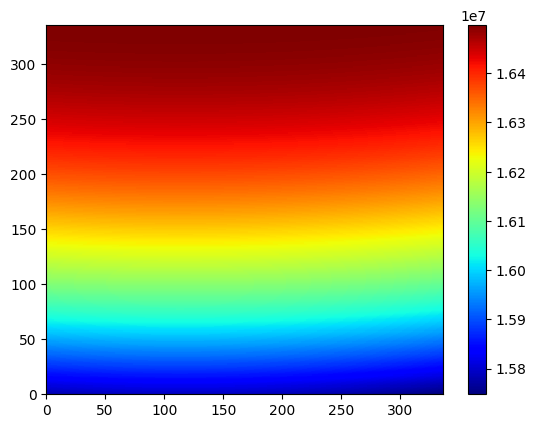

In [17]:
plt.pcolormesh(ds_save['c404_area'].values, cmap=plt.cm.jet)
plt.colorbar()